## Import and installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==4.28.0 datasets evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine ==

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0


In [ ]:
from datasets import ClassLabel, Features, Dataset
from transformers import (BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments,
                          DataCollatorWithPadding, TextClassificationPipeline)
import pandas as pd
from tqdm.auto import tqdm
import torch
import pickle
import numpy as np
import evaluate

In [ ]:
id2label = {n: tag for n, tag in enumerate([
    "lex",
    "ortho",
    "gov",
    "syntax",
    "asp",
    "prep",
    "constr",
    "ref",
    "agrcase",
    "conj",
    "punct",
    "agrgender",
    "agrnum",
    "num",
    "infl",
    "wo",
    "tense",
    "misspell",
    "brev",
    "gender",
    "deriv",
    "agrpers",
    "refl"
])}



label2id = {n : tag for tag, n in id2label.items()}

In [ ]:
label2id

{'lex': 0,
 'ortho': 1,
 'gov': 2,
 'syntax': 3,
 'asp': 4,
 'prep': 5,
 'constr': 6,
 'ref': 7,
 'agrcase': 8,
 'conj': 9,
 'punct': 10,
 'agrgender': 11,
 'agrnum': 12,
 'num': 13,
 'infl': 14,
 'wo': 15,
 'tense': 16,
 'misspell': 17,
 'brev': 18,
 'gender': 19,
 'deriv': 20,
 'agrpers': 21,
 'refl': 22}

In [ ]:
id2label

{0: 'lex',
 1: 'ortho',
 2: 'gov',
 3: 'syntax',
 4: 'asp',
 5: 'prep',
 6: 'constr',
 7: 'ref',
 8: 'agrcase',
 9: 'conj',
 10: 'punct',
 11: 'agrgender',
 12: 'agrnum',
 13: 'num',
 14: 'infl',
 15: 'wo',
 16: 'tense',
 17: 'misspell',
 18: 'brev',
 19: 'gender',
 20: 'deriv',
 21: 'agrpers',
 22: 'refl'}

## Preprocessing

In [ ]:
data = pd.read_csv('dataset_full_context.csv')
data

,text,tag
0,окружющей → окружающей | является загрязнение ...,ortho
1,промышленным → промышленных | почвы в промышле...,agrcase
2,"воздействую → воздействуя | разрушать его, воз...",syntax
3,желудожно-кишечный → желудочно-кишечный | нерв...,"ortho, altern"
4,"это → | организм - это воздушный, если → орг...",syntax
...,...,...
38273,Они → Им | Они были тяжело → Им были тяжело,gov
38274,были → было | Они были тяжело в → Они было тяж...,agrnum
38275,[MASK] → у | английский язык. → у,prep
38276,[MASK] → них | английский язык. → них,ref


In [ ]:
data = data.dropna()

In [ ]:
def split_tags(row):
    tags = row['tag'].split(',')
    return pd.DataFrame({'text': row['text'], 'tag': tags})


data = pd.concat(data.apply(split_tags, axis=1).tolist(), ignore_index=True)


print(data)

                                                    text      tag
0      окружющей → окружающей | является загрязнение ...    ortho
1      промышленным → промышленных | почвы в промышле...  agrcase
2      воздействую → воздействуя | разрушать его, воз...   syntax
3      желудожно-кишечный → желудочно-кишечный | нерв...    ortho
4      желудожно-кишечный → желудочно-кишечный | нерв...   altern
...                                                  ...      ...
44771        Они → Им | Они были тяжело → Им были тяжело      gov
44772  были → было | Они были тяжело в → Они было тяж...   agrnum
44773                  [MASK] → у | английский язык. → у     prep
44774              [MASK] → них | английский язык. → них      ref
44775  в вуз экзаменами → экзаменами в вуз | перед вс...       wo

[44776 rows x 2 columns]


In [ ]:
tag_counts = data['tag'].value_counts()
tag_counts

,count
tag,
lex,6990
syntax,5442
ortho,4297
gov,2822
constr,1764
...,...
рецензией,1
insert,1
addw,1


delete tags with counts < 200

In [ ]:
data['tag'] = data['tag'].str.strip()

data['tag'] = data['tag'].str.lower()


tag_counts = data['tag'].value_counts()


data = data[data['tag'].map(tag_counts) >= 200]

tag_counts = data['tag'].value_counts()


print(tag_counts)

tag
lex          7888
syntax       5572
ortho        4643
gov          3426
constr       2859
prep         2117
ref          1811
asp          1487
conj         1362
agrcase      1291
agrnum       1163
wo           1109
agrgender    1092
num          1033
infl          974
punct         854
tense         595
space         553
misspell      418
brev          371
deriv         358
gender        328
refl          305
agrpers       297
hyphen        255
par           251
idiom         249
agrstr        245
aux           240
impers        222
Name: count, dtype: int64


In [ ]:
data['label'] = data['tag'].map(label2id)

<ipython-input-14-f78e78428c20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['tag'].map(label2id)


In [ ]:
data

,text,tag,label
0,окружющей → окружающей | является загрязнение ...,ortho,1.0
1,промышленным → промышленных | почвы в промышле...,agrcase,8.0
2,"воздействую → воздействуя | разрушать его, воз...",syntax,3.0
3,желудожно-кишечный → желудочно-кишечный | нерв...,ortho,1.0
5,"это → | организм - это воздушный, если → орг...",syntax,3.0
...,...,...,...
44771,Они → Им | Они были тяжело → Им были тяжело,gov,2.0
44772,были → было | Они были тяжело в → Они было тяж...,agrnum,12.0
44773,[MASK] → у | английский язык. → у,prep,5.0
44774,[MASK] → них | английский язык. → них,ref,7.0


In [ ]:
data = data.dropna()

In [ ]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Fine-tuning Roberta

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


class RobertaWithAttention(nn.Module):
    def __init__(self, num_labels):
        super(RobertaWithAttention, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.attention = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 1),
            nn.Tanh()
        )
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        attention_scores = self.attention(hidden_states).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_hidden_states = torch.sum(hidden_states * attention_weights.unsqueeze(-1), dim=1)


        logits = self.classifier(weighted_hidden_states)
        return logits


def train_and_evaluate(data, num_labels, num_epochs=10, batch_size=8, max_len=128, lr=2e-5, save_dir="saved_models"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")

    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    dataset = TextDataset(data, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    model = RobertaWithAttention(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_top3 = 0
        total_samples = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(dataloader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Top-3 accuracy for the current batch
            top3_preds = torch.topk(logits, 3, dim=1).indices
            correct_top3 += sum([label in preds for label, preds in zip(labels.tolist(), top3_preds.tolist())])
            total_samples += labels.size(0)

        epoch_accuracy = correct_top3 / total_samples
        print(f"Loss: {epoch_loss / len(dataloader):.4f}, Top-3 Accuracy: {epoch_accuracy:.4f}")

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f"model_5words_04_04_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

    return model

if __name__ == "__main__":

    data = data


    model = train_and_evaluate(data, num_labels=data['label'].nunique())

    MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_04_04.pth'



    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Модель сохранена в {MODEL_PATH}")


Используемое устройство: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Loss: 1.7437, Top-3 Accuracy: 0.7091
Model saved at saved_models/model_5words_04_04_epoch_1.pth

Epoch 2/10


Loss: 1.3706, Top-3 Accuracy: 0.8108
Model saved at saved_models/model_5words_04_04_epoch_2.pth

Epoch 3/10


Loss: 1.2741, Top-3 Accuracy: 0.8321
Model saved at saved_models/model_5words_04_04_epoch_3.pth

Epoch 4/10


Loss: 1.2039, Top-3 Accuracy: 0.8508
Model saved at saved_models/model_5words_04_04_epoch_4.pth

Epoch 5/10


Loss: 1.1502, Top-3 Accuracy: 0.8628
Model saved at saved_models/model_5words_04_04_epoch_5.pth

Epoch 6/10


Loss: 1.1024, Top-3 Accuracy: 0.8738
Model saved at saved_models/model_5words_04_04_epoch_6.pth

Epoch 7/10


Loss: 1.0663, Top-3 Accuracy: 0.8831
Model saved at saved_models/model_5words_04_04_epoch_7.pth

Epoch 8/10


Loss: 1.0326, Top-3 Accuracy: 0.8884
Model saved at saved_models/model_5words_04_04_epoch_8.pth

Epoch 9/10


Loss: 0.9849, Top-3 Accuracy: 0.8983
Model saved at saved_models/model_5words_04_04_epoch_9.pth

Epoch 10/10


Loss: 0.9517, Top-3 Accuracy: 0.9077
Model saved at saved_models/model_5words_04_04_epoch_10.pth
Модель сохранена в /content/drive/MyDrive/models/trained_model_5words_04_04.pth


In [ ]:

torch.save(model.state_dict(), "trained_model_5words_04_04.pth")



## Testing on test data

In [ ]:
import torch
import pandas as pd
from transformers import RobertaTokenizer

MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_04_04.pth'
TOKENIZER_PATH = "roberta-base"
OUTPUT_FILE = "new_rlc_test_with_predictions_5words.csv"


def load_model(model_path, num_labels):
    model = RobertaWithAttention(num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def predict(model, tokenizer, text, max_len=128, top_k=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1).squeeze(0)


        top_probs, top_indices = torch.topk(probabilities, k=top_k)
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()

    return top_indices, top_probs


if __name__ == "__main__":

    allowed_tags = [
        "lex",
        "ortho",
        "gov",
        "syntax",
        "asp",
        "prep",
        "constr",
        "ref",
        "agrcase",
        "conj",
        "punct",
        "agrgender",
        "agrnum",
        "num",
        "infl",
        "wo",
        "tense",
        "misspell",
        "brev",
        "gender",
        "deriv",
        "agrpers",
        "refl"
    ]

    id2label = {n: tag for n, tag in enumerate(allowed_tags)}

    num_labels = len(allowed_tags)


    input_file = "rlc_test_context_5words.csv"
    data = pd.read_csv(input_file)
    data['tag'] = data['tag'].str.lower()
    data = data.dropna()


    data = data[data['tag'].isin(allowed_tags)]

    tokenizer = RobertaTokenizer.from_pretrained(TOKENIZER_PATH)
    model = load_model(MODEL_PATH, num_labels)


    predictions = []
    for text in data["text"]:
        top_indices, top_probs = predict(model, tokenizer, text, top_k=3)
        top_labels = [id2label[idx] for idx in top_indices]
        predictions.append(", ".join([f"{label} ({prob:.4f})" for label, prob in zip(top_labels, top_probs)]))

    data["top_3_predictions"] = predictions

    data.to_csv(OUTPUT_FILE, index=False)
    print(f"Результаты сохранены в файл: {OUTPUT_FILE}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Результаты сохранены в файл: new_rlc_test_with_predictions_5words.csv


## Confusion matrix

for 1 prediction

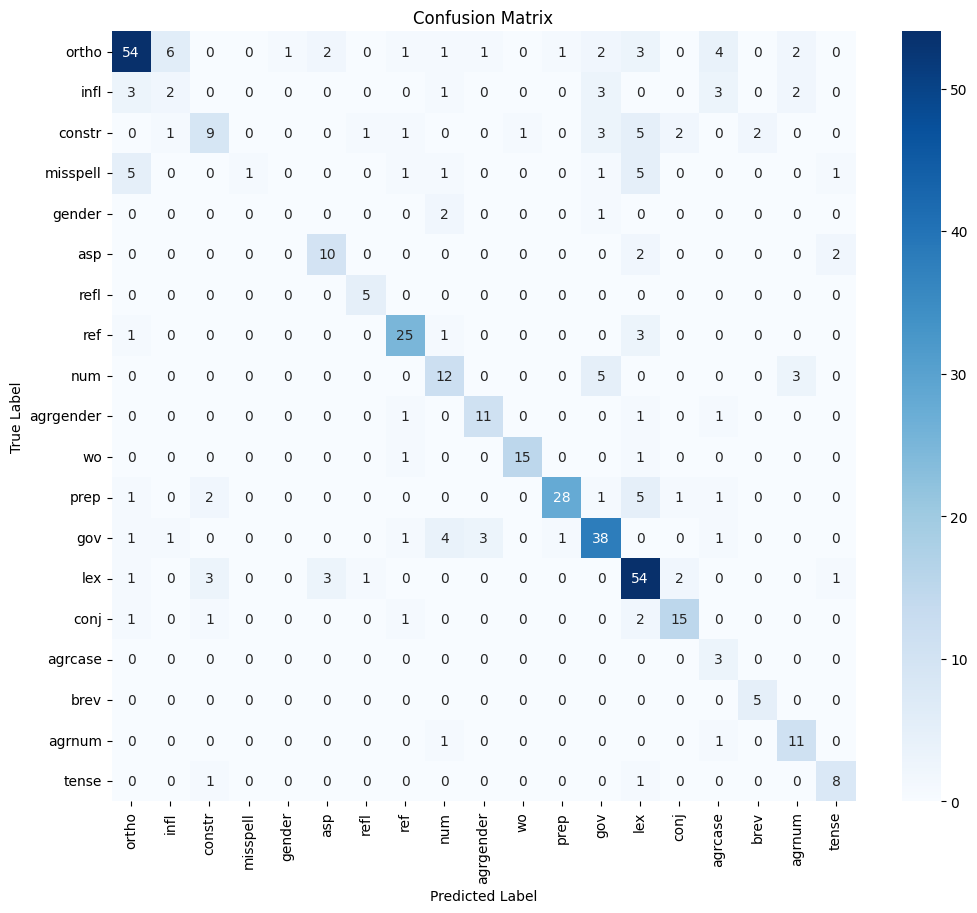

Classification Metrics:
              precision    recall  f1-score     support
agrcase        0.214286  1.000000  0.352941    3.000000
agrgender      0.733333  0.785714  0.758621   14.000000
agrnum         0.611111  0.785714  0.687500   14.000000
agrpers        0.000000  0.000000  0.000000    0.000000
asp            0.666667  0.714286  0.689655   14.000000
brev           0.714286  1.000000  0.833333    5.000000
conj           0.750000  0.652174  0.697674   23.000000
constr         0.562500  0.272727  0.367347   33.000000
deriv          0.000000  0.000000  0.000000    0.000000
gender         0.000000  0.000000  0.000000    3.000000
gov            0.703704  0.760000  0.730769   50.000000
infl           0.200000  0.133333  0.160000   15.000000
lex            0.658537  0.794118  0.720000   68.000000
misspell       1.000000  0.066667  0.125000   15.000000
num            0.521739  0.600000  0.558140   20.000000
ortho          0.805970  0.642857  0.715232   84.000000
prep           0.933333 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv("new_rlc_test_with_predictions_5words.csv")


def extract_top_prediction(row):
    top_3_predictions = row.split(", ")
    top_prediction = top_3_predictions[0].split(" ")[0]
    return top_prediction


data["predicted_tag"] = data["top_3_predictions"].apply(extract_top_prediction)


true_labels = data["tag"]
predicted_labels = data["predicted_tag"]


conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=true_labels.unique())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=true_labels.unique(), yticklabels=true_labels.unique(), cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print("Classification Metrics:")
print(report_df)

report_df.to_csv("classification_report.csv", index=True)


for 3 predictions

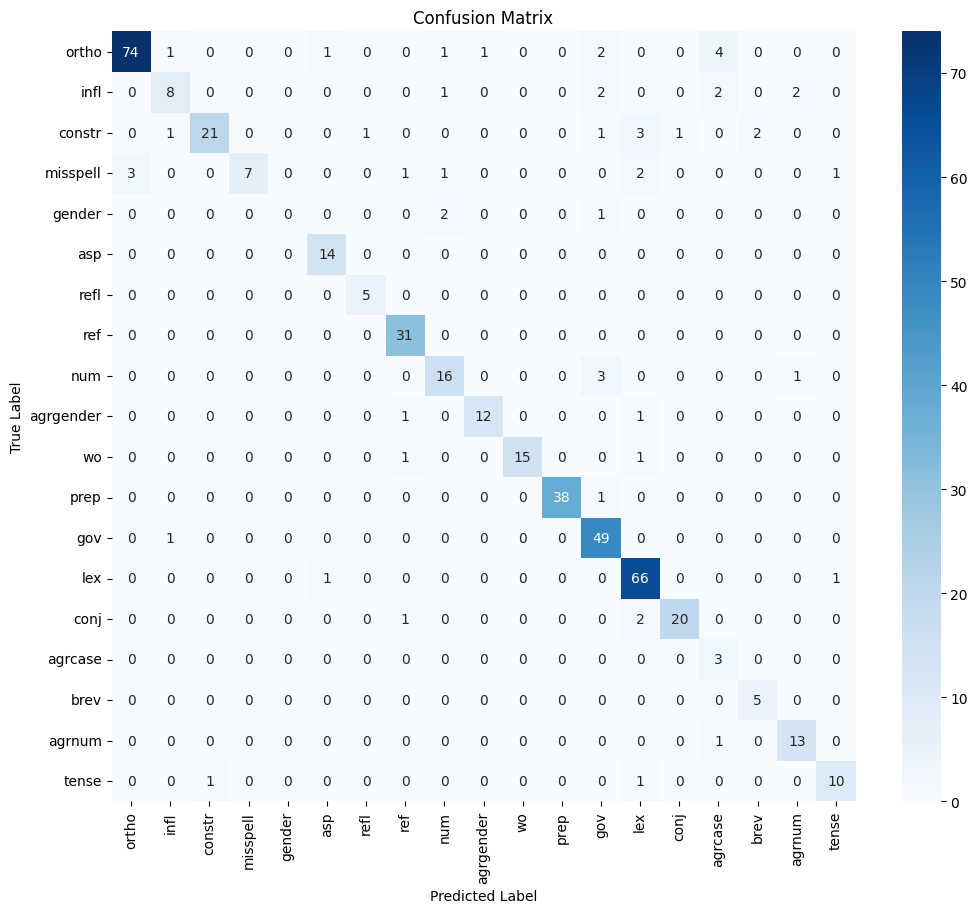

Classification Metrics:
              precision    recall  f1-score     support
agrcase        0.300000  1.000000  0.461538    3.000000
agrgender      0.923077  0.857143  0.888889   14.000000
agrnum         0.812500  0.928571  0.866667   14.000000
asp            0.875000  1.000000  0.933333   14.000000
brev           0.714286  1.000000  0.833333    5.000000
conj           0.952381  0.869565  0.909091   23.000000
constr         0.954545  0.636364  0.763636   33.000000
gender         0.000000  0.000000  0.000000    3.000000
gov            0.830508  0.980000  0.899083   50.000000
infl           0.727273  0.533333  0.615385   15.000000
lex            0.868421  0.970588  0.916667   68.000000
misspell       1.000000  0.466667  0.636364   15.000000
num            0.761905  0.800000  0.780488   20.000000
ortho          0.961039  0.880952  0.919255   84.000000
prep           1.000000  0.950000  0.974359   40.000000
ref            0.885714  1.000000  0.939394   31.000000
refl           0.833333 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("new_rlc_test_with_predictions_5words.csv")


def extract_predicted_tag(row):
    true_tag = row['tag']
    top_3_predictions = row['top_3_predictions'].split(", ")

    for prediction in top_3_predictions:
        predicted_tag = prediction.split(" ")[0]
        if predicted_tag == true_tag:
            return predicted_tag

    return top_3_predictions[0].split(" ")[0]


data["predicted_tag"] = data.apply(extract_predicted_tag, axis=1)


true_labels = data["tag"]
predicted_labels = data["predicted_tag"]


conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=true_labels.unique())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=true_labels.unique(), yticklabels=true_labels.unique(), cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print("Classification Metrics:")
print(report_df)


report_df.to_csv("classification_report.csv", index=True)